In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive, Output
from IPython.display import display, clear_output
import seaborn as sns
from statannotations.Annotator import Annotator

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [2]:
material = {
    "red":         {0: "#ffebee",1: "#ffcdd2",2: "#ef9a9a",3: "#e57373",4: "#ef5350",5: "#f44336",6: "#e53935",7: "#d32f2f",8: "#c62828",9: "#b71c1c",},
    "pink":        {0: "#fce4ec",1: "#f8bbd0",2: "#f48fb1",3: "#f06292",4: "#ec407a",5: "#e91e63",6: "#d81b60",7: "#c2185b",8: "#ad1457",9: "#880e4f",},
    "purple":      {0: "#f3e5f5",1: "#e1bee7",2: "#ce93d8",3: "#ba68c8",4: "#ab47bc",5: "#9c27b0",6: "#8e24aa",7: "#7b1fa2",8: "#6a1b9a",9: "#4a148c",},
    "dep purp":    {0: "#ede7f6",1: "#d1c4e9",2: "#b39ddb",3: "#9575cd",4: "#7e57c2",5: "#673ab7",6: "#5e35b1",7: "#512da8",8: "#4527a0",9: "#311b92",},
    "indigo":      {0: "#e8eaf6",1: "#c5cae9",2: "#9fa8da",3: "#7986cb",4: "#5c6bc0",5: "#3f51b5",6: "#3949ab",7: "#303f9f",8: "#283593",9: "#1a237e",},
    "blue":        {0: "#e3f2fd",1: "#bbdefb",2: "#90caf9",3: "#64b5f6",4: "#42a5f5",5: "#2196f3",6: "#1e88e5",7: "#1976d2",8: "#1565c0",9: "#0d47a1",},
    "lit blu":     {0: "#e1f5fe",1: "#b3e5fc",2: "#81d4fa",3: "#4fc3f7",4: "#29b6f6",5: "#03a9f4",6: "#039be5",7: "#0288d1",8: "#0277bd",9: "#01579b",},
    "cyan":        {0: "#e0f7fa",1: "#b2ebf2",2: "#80deea",3: "#4dd0e1",4: "#26c6da",5: "#00bcd4",6: "#00acc1",7: "#0097a7",8: "#00838f",9: "#006064",},
    "teal":        {0: "#e0f2f1",1: "#b2dfdb",2: "#80cbc4",3: "#4db6ac",4: "#26a69a",5: "#009688",6: "#00897b",7: "#00796b",8: "#00695c",9: "#004d40",},
    "green":       {0: "#e8f5e9",1: "#c8e6c9",2: "#a5d6a7",3: "#81c784",4: "#66bb6a",5: "#4caf50",6: "#43a047",7: "#388e3c",8: "#2e7d32",9: "#1b5e20",},
    "lit grn":     {0: "#f1f8e9",1: "#dcedc8",2: "#c5e1a5",3: "#aed581",4: "#9ccc65",5: "#8bc34a",6: "#7cb342",7: "#689f38",8: "#558b2f",9: "#33691e",},
    "lime":        {0: "#f9fbe7",1: "#f0f4c3",2: "#e6ee9c",3: "#dce775",4: "#d4e157",5: "#cddc39",6: "#c0ca33",7: "#afb42b",8: "#9e9d24",9: "#827717",},
    "yellow":      {0: "#fffde7",1: "#fff9c4",2: "#fff59d",3: "#fff176",4: "#ffee58",5: "#ffeb3b",6: "#fdd835",7: "#fbc02d",8: "#f9a825",9: "#f57f17",},
    "amber":       {0: "#fff8e1",1: "#ffecb3",2: "#ffe082",3: "#ffd54f",4: "#ffca28",5: "#ffc107",6: "#ffb300",7: "#ffa000",8: "#ff8f00",9: "#ff6f00",},
    "orange":      {0: "#fff3e0",1: "#ffe0b2",2: "#ffcc80",3: "#ffb74d",4: "#ffa726",5: "#ff9800",6: "#fb8c00",7: "#f57c00",8: "#ef6c00",9: "#e65100",},
    "dep ora":     {0: "#fbe9e7",1: "#ffccbc",2: "#ffab91",3: "#ff8a65",4: "#ff7043",5: "#ff5722",6: "#f4511e",7: "#e64a19",8: "#d84315",9: "#bf360c",},
    "brown":       {0: "#efebe9",1: "#d7ccc8",2: "#bcaaa4",3: "#a1887f",4: "#8d6e63",5: "#795548",6: "#6d4c41",7: "#5d4037",8: "#4e342e",9: "#3e2723",},
    "grey":        {0: "#fafafa",1: "#f5f5f5",2: "#eeeeee",3: "#e0e0e0",4: "#bdbdbd",5: "#9e9e9e",6: "#757575",7: "#616161",8: "#424242",9: "#212121",},
    "blu gry":     {0: "#eceff1",1: "#cfd8dc",2: "#b0bec5",3: "#90a4ae",4: "#78909c",5: "#607d8b",6: "#546e7a",7: "#455a64",8: "#37474f",9: "#263238",},
    }

In [35]:
df = pd.read_csv('data/smiles_box_plot.csv')

display(df.head())
print(df.shape)

,TAG,SMILES,atp_SMILES
0,CHEMBL(929),CC(C)c1cc(CNc2nc(Nc3cc(C4CC4)[nH]n3)cc(N3CCN(C...,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
1,CHEMBL(929),COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C...,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
2,CHEMBL(929),CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
3,CHEMBL(929),C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4c(c5c6...,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
4,CHEMBL(929),COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncnc(Nc2cc...,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...


(53657, 3)


In [36]:
def process_df(df):
    df4 = pd.DataFrame({'TAG': df['TAG']})
    df4['similarity_score'] = 0.0  

    def calculate_similarity(row):
        m1 = Chem.MolFromSmiles(row['SMILES'])
        m2 = Chem.MolFromSmiles(row['atp_SMILES'])
        
        if m1 is not None and m2 is not None:
            invgen = AllChem.GetMorganFeatureAtomInvGen()
            ffpgen = AllChem.GetMorganGenerator(radius=2, atomInvariantsGenerator=invgen)
            
            ffp1 = ffpgen.GetSparseCountFingerprint(m1)
            ffp2 = ffpgen.GetSparseCountFingerprint(m2)
            
            similarity_score = DataStructs.TanimotoSimilarity(ffp1, ffp2)
            return similarity_score
        else:
            return None

    df4['similarity_score'] = df.apply(calculate_similarity, axis=1)
    return df4

df1 = process_df(df)

display(df1.head())
print(df1.shape)

,TAG,similarity_score
0,CHEMBL(929),0.158940
1,CHEMBL(929),0.167832
2,CHEMBL(929),0.230216
3,CHEMBL(929),0.178808
4,CHEMBL(929),0.169591


(53657, 2)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CHEMBL(929) vs. HINGE(24000): Mann-Whitney-Wilcoxon test two-sided, P_val:2.624e-01 U_stat=1.139e+07
HINGE(24000) vs. ANTI_BACTERIAL(28728): Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.375e+08
CHEMBL(929) vs. ANTI_BACTERIAL(28728): Mann-Whitney-Wilcoxon test two-sided, P_val:7.589e-52 U_stat=9.453e+06


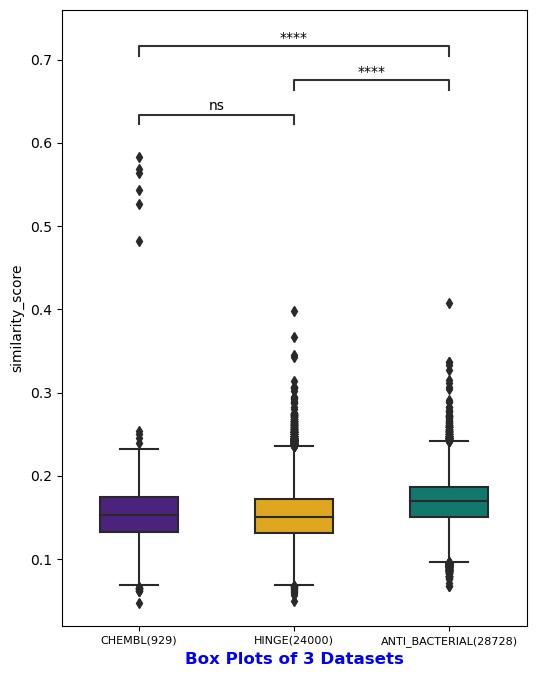

In [83]:
x = "TAG"
y = "similarity_score"
order = ['CHEMBL(929)', 'HINGE(24000)', 'ANTI_BACTERIAL(28728)']

batch_colors_light = {'CHEMBL(929)': material['purple'][9], 'HINGE(24000)': material['amber'][6], 'ANTI_BACTERIAL(28728)': material['teal'][6],}

fig, ax = plt.subplots(figsize=(6, 8))
ax = sns.boxplot(data=df1, x=x, y=y, order=order, palette=batch_colors_light.values(), width=0.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8) 
ax.set_xlabel('Box Plots of 3 Datasets', fontsize=12, fontweight='bold', color='blue')

pairs=[("CHEMBL(929)", "HINGE(24000)"), ("HINGE(24000)", "ANTI_BACTERIAL(28728)"), ("ANTI_BACTERIAL(28728)", "CHEMBL(929)")]
annotator = Annotator(ax, pairs, data=df1, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('box_plot.png')